In [1]:
from flask import (
    Flask,
    render_template,
    jsonify)
from flask_pymongo import PyMongo
import pandas as pd
from pymongo import MongoClient
import json
from bson import json_util
from bson.json_util import dumps
#import dash
#import dash_core_components as dcc
#import dash_html_components as html
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import numpy as np #importing Numpy
%matplotlib inline 

#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #initiating VADER instance

import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize  # to split sentences into words
from nltk.corpus import stopwords  # to get a list of stopwords
from collections import Counter  # to get words-frequency


analyser = SentimentIntensityAnalyzer()

app = Flask(__name__)

analyser = SentimentIntensityAnalyzer()

mongo = PyMongo(app, uri="mongodb://localhost:27017/billboard_db")
music = mongo.db.all_number_one_songs

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nlgrove\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nlgrove\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nlgrove\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [2]:
df = pd.DataFrame(list(music.find()))

In [3]:
df = df.drop(['_id'], axis=1)

In [4]:
len(df)

1203

In [5]:
df.isna().sum()

artist          0
issue_date      0
lyrics        148
title           0
year            0
dtype: int64

In [6]:
####dropping rows with null values
reduced_df = df.dropna(how='any')

In [7]:
reduced_df.isna().sum()

artist        0
issue_date    0
lyrics        0
title         0
year          0
dtype: int64

In [8]:
reduced_df.head(200)

,artist,issue_date,lyrics,title,year
0,Ricky Nelson,"[August 4, August 11]",I used to play around with hearts That hasten...,Poor Little Fool,1958
1,Domenico Modugno,[August 18],Penso che un sogno così non ritorni mai più M...,Nel Blu Dipinto Di Blu (Volaré),1958
2,The Elegants,[August 25],Where are you little star (Where are you )Who...,Little Star,1958
4,Tommy Edwards,"[September 29, October 6, October 13, October ...",,It's All In The Game,1958
5,Conway Twitty,[November 10],People see us everywhere They think you reall...,It's Only Make Believe,1958
6,The Kingston Trio,[November 17],,Tom Dooley,1958
8,The Teddy Bears,"[December 1, December 8, December 15]",To know know know him Is to love love lov...,"To Know Him, Is To Love Him",1958
9,The Chipmunks With David Seville,"[December 22, December 29]",,The Chipmunk Song,1958
11,The Platters,"[January 19, January 26, February 2]",They asked me how I knew My true love was tru...,Smoke Gets In Your Eyes,1959
12,Lloyd Price,"[February 9, February 16, February 23, March 2]",The night was clear And the moon was yellow A...,Stagger Lee,1959


In [9]:
len(reduced_df)

1055

In [10]:
lyrics_index = reduced_df.set_index("lyrics")

In [11]:
%time   #to calulate the time it takes the algorithm to compute a VADER score

i=0 #counter

compval1 = [ ]  #empty list to hold our computed 'compound' VADER scores


while (i<len(reduced_df)):

    k = analyser.polarity_scores(reduced_df.iloc[i]['lyrics'])
    compval1.append(k['compound'])
    
    i = i+1
    
#converting sentiment values to numpy for easier usage

compval1 = np.array(compval1)

len(compval1)

Wall time: 0 ns


1055

In [12]:
compval1

array([-0.9856,  0.    ,  0.9661, ...,  0.9953,  0.9817,  0.8316])

In [13]:
reduced_df['VADER score'] = compval1

C:\Users\nlgrove\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [14]:
%time

#Assigning score categories and logic
i = 0
predicted_value =[]

while(i<len(reduced_df)):
    if ((reduced_df.iloc[i]['VADER score'] >= 0.5)):
        predicted_value.append('positive')
        i = i+1
    elif ((reduced_df.iloc[i]['VADER score'] > 0) & (reduced_df.iloc[i]['VADER score'] < 0.5)):
        predicted_value.append('neutral')
        i = i+1
    elif ((reduced_df.iloc[i]['VADER score'] == 0)):
        predicted_value.append('NA')
        i = i+1
    elif ((reduced_df.iloc[i]['VADER score'] < 0)):
        predicted_value.append('negative')
        i = i+1

Wall time: 0 ns


In [15]:
reduced_df['sentiment'] = predicted_value

C:\Users\nlgrove\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [16]:
reduced_df.head(20)

,artist,issue_date,lyrics,title,year,VADER score,sentiment
0,Ricky Nelson,"[August 4, August 11]",I used to play around with hearts That hasten...,Poor Little Fool,1958,-0.9856,negative
1,Domenico Modugno,[August 18],Penso che un sogno così non ritorni mai più M...,Nel Blu Dipinto Di Blu (Volaré),1958,0.0000,NA
2,The Elegants,[August 25],Where are you little star (Where are you )Who...,Little Star,1958,0.9661,positive
4,Tommy Edwards,"[September 29, October 6, October 13, October ...",,It's All In The Game,1958,0.0000,NA
5,Conway Twitty,[November 10],People see us everywhere They think you reall...,It's Only Make Believe,1958,0.9870,positive
6,The Kingston Trio,[November 17],,Tom Dooley,1958,0.0000,NA
8,The Teddy Bears,"[December 1, December 8, December 15]",To know know know him Is to love love lov...,"To Know Him, Is To Love Him",1958,0.9954,positive
9,The Chipmunks With David Seville,"[December 22, December 29]",,The Chipmunk Song,1958,0.0000,NA
11,The Platters,"[January 19, January 26, February 2]",They asked me how I knew My true love was tru...,Smoke Gets In Your Eyes,1959,0.9863,positive
12,Lloyd Price,"[February 9, February 16, February 23, March 2]",The night was clear And the moon was yellow A...,Stagger Lee,1959,0.7430,positive


In [17]:
reduced_df.drop(reduced_df[reduced_df['sentiment'] == 'NA'].index , inplace=True)

C:\Users\nlgrove\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



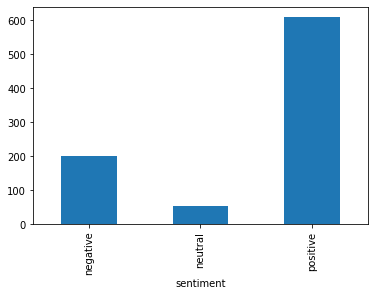

In [18]:
reduced_df.groupby('sentiment').size().plot(kind='bar')

In [19]:
plt.savefig('sentiment.png')

<Figure size 432x288 with 0 Axes>

In [20]:
bins = [1950,1960,1970,1980,1990,2000,2010,2020]
group_names =["50s","60s","70s","80s","90s","2000s","2010s"]
# Slice the data and place it into bins
reduced_df["decade"] = pd.cut(reduced_df["year"], bins, labels=group_names, right=False)


C:\Users\nlgrove\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [21]:
df60s = reduced_df[reduced_df['decade']=='60s']

comment_words =''
# iterate through the csv file 
for val in df60s['lyrics']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '


In [22]:
words = word_tokenize(comment_words)

        # get stopwords
stop_words = set(stopwords.words('english'))

        # remove stopwords from our words list and also remove any word whose length is less than 3
        # stopwords are commonly occuring words like is, am, are, they, some, etc.
words = [word for word in words if word not in stop_words and len(word) > 3]

        # now, get the words and their frequency
words_freq = Counter(words)

        # JQCloud requires words in format {'text': 'sample', 'weight': '100'}
        # so, lets convert out word_freq in the respective format
words_json = [{'text': word, 'weight': count} for word, count in words_freq.items()]


In [23]:
words_json

[{'text': 'west', 'weight': 4},
 {'text': 'texas', 'weight': 3},
 {'text': 'town', 'weight': 20},
 {'text': 'paso', 'weight': 1},
 {'text': 'fell', 'weight': 5},
 {'text': 'love', 'weight': 376},
 {'text': 'mexican', 'weight': 2},
 {'text': 'girl', 'weight': 91},
 {'text': 'nighttime', 'weight': 1},
 {'text': 'would', 'weight': 54},
 {'text': 'find', 'weight': 29},
 {'text': 'rosa', 'weight': 1},
 {'text': 'cantina', 'weight': 1},
 {'text': 'music', 'weight': 6},
 {'text': 'play', 'weight': 33},
 {'text': 'feleena', 'weight': 3},
 {'text': 'whirlblacker', 'weight': 1},
 {'text': 'night', 'weight': 52},
 {'text': 'eyes', 'weight': 23},
 {'text': 'wicked', 'weight': 2},
 {'text': 'evil', 'weight': 2},
 {'text': 'casting', 'weight': 1},
 {'text': 'spell', 'weight': 2},
 {'text': 'deep', 'weight': 12},
 {'text': 'maiden', 'weight': 2},
 {'text': 'vain', 'weight': 1},
 {'text': 'could', 'weight': 64},
 {'text': 'tellone', 'weight': 1},
 {'text': 'wild', 'weight': 14},
 {'text': 'young', 'we